In [28]:
import os
import matplotlib.pyplot as plt
import random
import cv2
import numpy as np
from keras.models import load_model,save_model,Sequential
from keras.layers import Activation,Conv2D,Dense,Dropout,Flatten,MaxPooling2D
from keras.preprocessing import image
from keras.utils import to_categorical

In [29]:
center = 112
upper_bound, lower_bound = 224, 0
pad = 10
region_ul, region_ll = 5000, 150
thresh_ul, thresh_ll = 255, 127
train_data = []
test_data = []
X_train = []
y_train = []
X_test = []
y_test = []
shape = [224,224,3]

In [30]:
train_dir = 'D:/Programs/Python/DATA/SkinCancer/data/train'
test_dir = 'D:/Programs/Python/DATA/SkinCancer/data/test'
Categories = ['benign','malignant']

In [31]:
def initialPrepare(img):
    blur = cv2.medianBlur(img,5)
    img = cv2.cvtColor(blur,cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    _,thresh = cv2.threshold(gray,thresh_ll,thresh_ul,cv2.THRESH_BINARY_INV)
    return thresh

In [32]:
def findDist(x,y):
    X = (center-x)*(center-x)
    Y = (center-y)*(center-y)
    return X+Y

In [33]:
def check(region_size):
    if(region_size<region_ul and region_size>region_ll):
            return True
    return False

In [34]:
def centroid(contour):
    centroidXY = cv2.moments(contour)
    x = int(centroidXY['m10']/centroidXY['m00'])
    y = int(centroidXY['m01']/centroidXY['m00'])
    return x,y

In [35]:
def finalRegion(curr_contour):
    perimeter = cv2.arcLength(curr_contour, True)
    box = cv2.approxPolyDP(curr_contour, 0.02 * perimeter, True)
    x , y , w, h = cv2.boundingRect(box)
    return x, y, w, h

In [36]:
def show_images(y,X_images):
    c = 5
    r = 3
    fig = plt.figure(figsize=(12, 12))
    for i in range(1,r*c+1):
        ax = fig.add_subplot(r,c,i)
        if y[i] == 0:
            ax.title.set_text('Benign')
        else :
            ax.title.set_text('Malignant')
        plt.imshow(X_images[i], interpolation='nearest')
    plt.show()

In [37]:
def preprocess(img):
    thresh=initialPrepare(img)
    _,contours,_ = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)

    max_val,curr_contour = 100000,contours[0]
    for contour in contours:
        region_size = cv2.contourArea(contour)
        ok = check(region_size)
        if(ok):
            x,y = centroid(contour)
            distance = findDist(x,y)
            if distance < max_val:
                curr_contour = contour
                max_val = distance  
    x_b ,y_b ,w ,h = finalRegion(curr_contour)
    x_f = max(lower_bound,x_b - pad)
    x_fb = min(upper_bound,x_b + w + pad)
    y_f = max(lower_bound,y_b - pad)
    y_fb = min(upper_bound,y_b + h + pad)

    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    final_img = img[y_f:y_fb,x_f:x_fb]
    final_img = cv2.resize(final_img,(224,224))
    return final_img

In [38]:
def prepare_train_data():
    for category in Categories:
        path = os.path.join(train_dir,category)
        cat_idx = Categories.index(category)
        for img in os.listdir(path):
            try:
                image = cv2.imread(os.path.join(path,img))
                image = preprocess(image)
                train_data.append([image,cat_idx])
            except Exception as e:
                pass
prepare_train_data()

In [39]:
random.shuffle(train_data)

In [40]:
for features,labels in train_data:
    X_train.append(features)
    y_train.append(labels)

In [41]:
X_train = np.array(X_train).reshape(-1,shape[0],shape[1],shape[2])
X_train = X_train/255
y_cat_train = to_categorical(y_train,2)

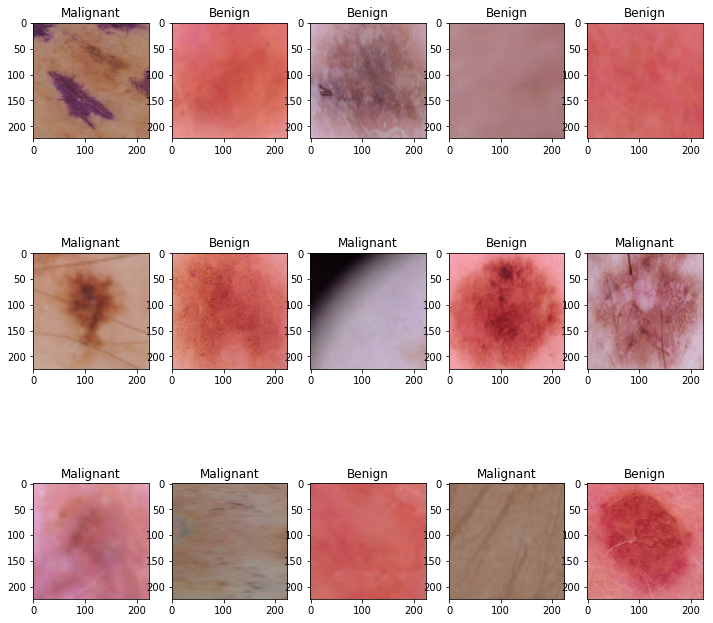

In [42]:
show_images(y_train,X_train)

In [43]:
def prepare_test_data():
    for category in Categories:
        path = os.path.join(test_dir,category)
        cat_idx = Categories.index(category)
        for img in os.listdir(path):
            try:
                image = cv2.imread(os.path.join(path,img))
                image = preprocess(image) 
                test_data.append([image,cat_idx])
            except Exception as e:
                pass
prepare_test_data()

In [44]:
random.shuffle(test_data)

In [45]:
for features,labels in test_data:
    X_test.append(features)
    y_test.append(labels)

In [46]:
X_test = np.array(X_test).reshape(-1,shape[0],shape[1],shape[2])
X_test=X_test/255
y_cat_test = to_categorical(y_test,2)

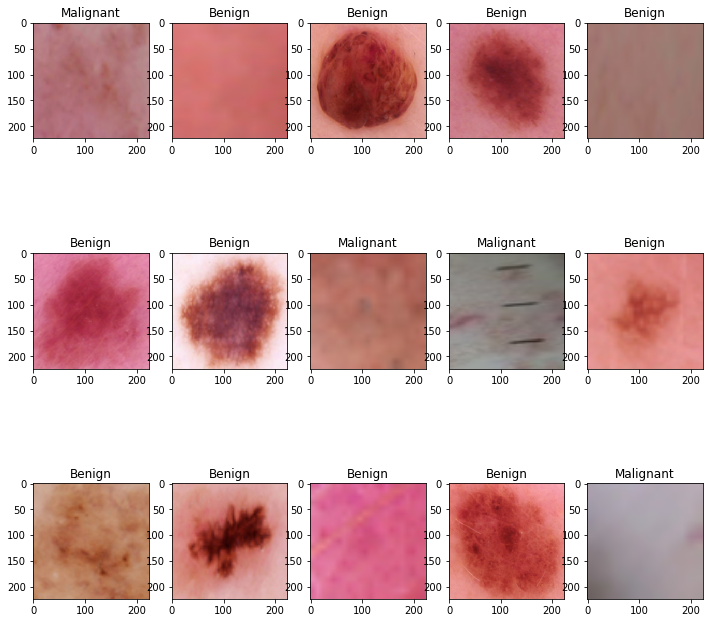

In [47]:
show_images(y_test,X_test)

In [ ]:
def train_model():
    model = Sequential()
    model.add(Conv2D(filters=64,kernel_size=(3,3),input_shape=(224,224,3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64,kernel_size=(3,3),input_shape=(224,224,3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64,kernel_size=(3,3),input_shape=(224,224,3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(Dense(2,activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.fit(X_train,y_cat_train,epochs=5)
    return model
model = train_model()

In [ ]:
def eval_model(model,X_test,y_cat_test):
    model.evaluate(X_test,y_cat_test)
eval_model(model,X_test,y_cat_test)

In [ ]:
def save_model(model):
    model.save('D:\Programs\Python\Projects\SkinCancer\Skin_Cancer(Classification).h5')
save_model(model)